In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/DVA 6242 Team Project/Datasets

/content/drive/MyDrive/DVA 6242 Team Project/Datasets


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import matplotlib.pyplot as plt

**Load data from datasets.**

In [ ]:
los_angeles_trees_df = pd.read_csv('LOS_ANGELES_TREES.csv')

<ipython-input-4-7d28508f1f06>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  los_angeles_trees_df = pd.read_csv('LOS_ANGELES_TREES.csv')


**Tree Classification in Los Angeles**



In [ ]:
# Encode categorical variables (species, diameter, condition, nativity, height, age).
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
los_angeles_trees_df['species_encoded'] = label_encoder.fit_transform(los_angeles_trees_df['common_name'])
los_angeles_trees_df['condition_encoded'] = label_encoder.fit_transform(los_angeles_trees_df['condition'])

In [ ]:
# Define explanatory variables.
x_variables = ['species_encoded', 'city_ID', 'diameter_breast_height_CM', 'height_M']
y_variables = ['condition_encoded']

In [ ]:
X = los_angeles_trees_df[x_variables]
y = los_angeles_trees_df[y_variables]

**Splitting into testing & training sets.**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Decision Tree Classifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree_classifier = DecisionTreeClassifier(random_state=42)
tree_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
y_pred = tree_classifier.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.65


**Using neural network for regression**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(np.unique(y)), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
6559/6559 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.0412 - loss: nan - val_accuracy: 0.0426 - val_loss: nan
Epoch 2/50
6559/6559 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.0418 - loss: nan - val_accuracy: 0.0426 - val_loss: nan
Epoch 3/50
6559/6559 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.0411 - loss: nan - val_accuracy: 0.0426 - val_loss: nan
Epoch 4/50
6559/6559 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.0415 - loss: nan - val_accuracy: 0.0426 - val_loss: nan
Epoch 5/50
6559/6559 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.0416 - loss: nan - val_accuracy: 0.0426 - val_loss: nan
Epoch 6/50
6559/6559 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.0428 - loss: nan - val_accuracy: 0.0426 - val_loss: nan
Epoch 7/50
6559/6559 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.0421 - loss: nan - val_accuracy: 0.0426 - val_loss: nan
Epoch 8/50
6559/6559 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.0417 - loss: nan - val_accuracy: 0.0426 - val_loss: nan


In [ ]:
from sklearn.metrics import accuracy_score
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f'Neural Network Accuracy: {test_acc:.2f}')

Neural Network Accuracy: 0.04


**Tree Health Classification for ALL US cities**

**Load and preprocess the data**

Load data from datasets.

In [ ]:
all_trees_df = pd.read_csv('ALL_TREE_DATASETS.csv')

<ipython-input-5-ffe0f97a6ef2>:1: DtypeWarning: Columns (0,1,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  all_trees_df = pd.read_csv('ALL_TREE_DATASETS.csv')


Drop rows where most_recent_observation is missing, or where tree condition is empty.

In [ ]:
all_trees_df = all_trees_df.dropna(subset=["most_recent_observation"])

In [ ]:
# Remove rows where tree condition is empty
all_trees_df = all_trees_df[all_trees_df['condition'] != ' ']

Handle missing values for dimensions (height and diameter).

In [ ]:
# Compute average height_M and diameter_breast_height_CM for each city, and use those values to replace missing values
# For example, if Atlanta's average height_M is some value X, then every missing value of height_M in a row whose city is Atlanta should be replaced by X.
all_trees_df.loc[:, 'height_M'] = all_trees_df.groupby('city')['height_M'].transform(lambda x: x.fillna(x.mean()))
all_trees_df.loc[:, 'diameter_breast_height_CM'] = all_trees_df.groupby('city')['diameter_breast_height_CM'].transform(lambda x: x.fillna(x.mean()))

Add a column denoting age based on most_recent_observation.

In [ ]:
# Convert the column to datetime, coercing errors to NaT
all_trees_df["date_parsed"] = pd.to_datetime(all_trees_df["most_recent_observation"], format="%m/%d/%Y", errors='coerce')

# Filter out invalid years (note: the data is from the year 2022)
all_trees_df = all_trees_df[(all_trees_df["date_parsed"].dt.year >= 1900) & (all_trees_df["date_parsed"].dt.year <= 2022)]

# Add column for age
all_trees_df['age'] = 2022 - all_trees_df['date_parsed'].dt.year

# Drop the temporary column
all_trees_df = all_trees_df.drop(columns=["date_parsed"])

<ipython-input-10-23cc15424cf6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_trees_df['age'] = 2022 - all_trees_df['date_parsed'].dt.year


Encode categorical variables.

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder = LabelEncoder()
all_trees_df['common_name_encoded'] = label_encoder.fit_transform(all_trees_df['common_name'])
all_trees_df['city_encoded'] = label_encoder.fit_transform(all_trees_df['city'])
all_trees_df['native_encoded'] = label_encoder.fit_transform(all_trees_df['native'])
all_trees_df['condition_encoded'] = label_encoder.fit_transform(all_trees_df['condition'])

**Use this to get the categorical value an encoding corresponds to**

In [ ]:
label_encoders = {}

for col in ['common_name', 'city', 'native', 'condition']:
    label_encoders[col] = LabelEncoder()
    all_trees_df[f'{col}_encoded'] = label_encoders[col].fit_transform(all_trees_df[col])

Keep only the necessary columns. Also, if a column is entirely null (NaN), then we drop such column.

In [ ]:
X_variables = ['common_name_encoded', 'city_encoded', 'native_encoded', 'height_M', 'diameter_breast_height_CM', 'age']
y_variable = ['condition']

In [ ]:
X = all_trees_df[X_variables]
y = all_trees_df[y_variable]

**Split data into train (80%) and test (20%) tests**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Random forest classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

Train the random forest classifier.

In [ ]:
classifier = RandomForestClassifier(n_estimators=25, max_depth=6, random_state=42)
classifier.fit(X_train, y_train.values.ravel())

RandomForestClassifier(max_depth=6, n_estimators=25, random_state=42)

Evaluate the performance of the random forest classifier.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [ ]:
y_pred = classifier.predict(X_test)

Accuracy: 73.30%


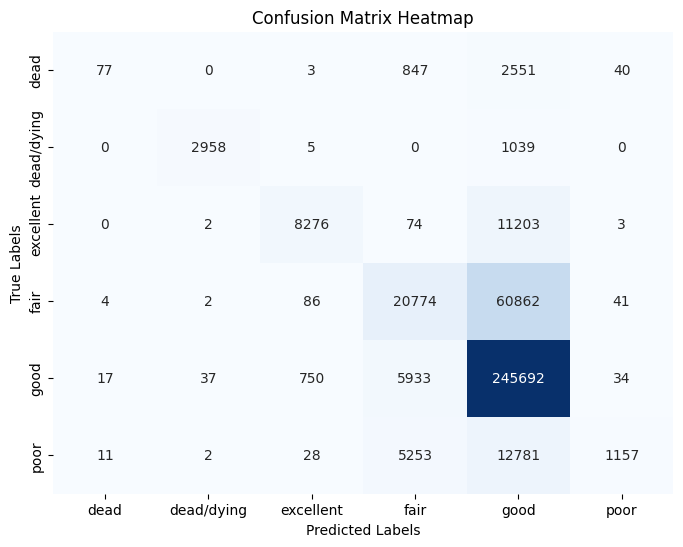

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

conf_matrix = confusion_matrix(y_test, y_pred)
condition_labels = label_encoders['condition'].classes_

plt.figure(figsize=(8, 6))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=condition_labels, yticklabels=condition_labels)

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Visualize the decision trees in the random forest classifier.

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [ ]:
%cd /content/drive/MyDrive/DVA 6242 Team Project/Visualizations/Tree Health

In [ ]:
for i in range(20):
    visualization = classifier.estimators_[i]
    plt.figure(figsize=(40, 10))
    plot_tree(visualization, filled=True, feature_names=X_train.columns, class_names=classifier.classes_, rounded=True, proportion=False)
    plt.title(f"Decision Tree #{i} of the Random Forest Classifier")
    # Save the figure
    plt.savefig(f"decision_tree_{i}.png", dpi=300, bbox_inches="tight")

**Save the model.**

In [ ]:
%cd /content/drive/MyDrive/DVA 6242 Team Project/Code/

/content/drive/MyDrive/DVA 6242 Team Project/Code


In [ ]:
import pickle

In [ ]:
filename = 'tree_health_random_forest_classifier.sav'
pickle.dump(classifier, open(filename, 'wb'))

# Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Sample 10% of the data
sampled_df = all_trees_df.sample(frac=0.1, random_state=42)

In [ ]:
X_sample = sampled_df[X_variables]
y_sample = sampled_df[['condition_encoded']]

In [ ]:
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample
)

In [ ]:
param_grid = {
    'n_estimators': [25],
    'max_depth': [12, 15],
    'min_samples_split': [2, 5],
}

In [ ]:
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train_sample, y_train_sample.values.ravel())

print("Best params:", grid_search.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 25}


In [ ]:
best_model = grid_search.best_estimator_

In [ ]:
y_pred = best_model.predict(X_test_sample)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(f"Sampled Accuracy: {accuracy_score(y_test_sample, y_pred) * 100:.2f}%")

Sampled Accuracy: 75.72%


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': [10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

In [ ]:
rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train_sample, y_train_sample.values.ravel())


Fitting 3 folds for each of 20 candidates, totalling 60 fits


KeyboardInterrupt: 

In [ ]:
print("Best hyperparameters:", random_search.best_params_)

best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test_sample)

from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test_sample, y_pred)
print(f"RandomizedSearchCV Accuracy: {accuracy * 100:.2f}%")

Best hyperparameters: {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 195}
RandomizedSearchCV Accuracy: 75.74%


# Introducing New Features

In [ ]:
# height_diameter_ratio
all_trees_df['height_diameter_ratio'] = all_trees_df['height_M'] / all_trees_df['diameter_breast_height_CM'].replace(0, 0.01)
if 'height_diameter_ratio' not in X_variables:
    X_variables.append('height_diameter_ratio')

In [ ]:
X = all_trees_df[X_variables]
y = all_trees_df[['condition_encoded']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    n_jobs=-1,
    random_state=42
)

classifier.fit(X_train, y_train.values.ravel())

KeyboardInterrupt: 

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 75.88%


In [ ]:
# age_diff_from_city_avg
city_avg_age = all_trees_df.groupby('city')['age'].transform('mean')
all_trees_df['age_diff_from_city_avg'] = all_trees_df['age'] - city_avg_age
if 'age_diff_from_city_avg' not in X_variables:
    X_variables.append('age_diff_from_city_avg')

In [ ]:
X = all_trees_df[X_variables]
y = all_trees_df[['condition_encoded']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    n_jobs=-1,
    random_state=42
)

classifier.fit(X_train, y_train.values.ravel())

y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with age_diff_from_city_avg: {accuracy * 100:.2f}%")

Accuracy with age_diff_from_city_avg: 75.91%


In [ ]:
city_avg_height = all_trees_df.groupby('city')['height_M'].transform('mean')
all_trees_df['height_diff_from_city_avg'] = all_trees_df['height_M'] - city_avg_height

if 'height_diff_from_city_avg' not in X_variables:
    X_variables.append('height_diff_from_city_avg')

X = all_trees_df[X_variables]
y = all_trees_df[['condition_encoded']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    n_jobs=-1,
    random_state=42
)

classifier.fit(X_train, y_train.values.ravel())

y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with age_diff_from_city_avg: {accuracy * 100:.2f}%")

Accuracy with age_diff_from_city_avg: 75.94%


## Feature Selection

In [ ]:
importances = classifier.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("Feature Importances:")
print(feature_importance_df)

top_features_df = feature_importance_df[feature_importance_df['importance'] >= 0.01]
top_features = top_features_df['feature'].tolist()

print("\nSelected top features (importance ≥ 0.01):")
print(top_features)

Feature Importances:
                     feature  importance
4  diameter_breast_height_CM    0.243250
1               city_encoded    0.228317
0        common_name_encoded    0.180199
5                        age    0.162788
7     age_diff_from_city_avg    0.125663
2             native_encoded    0.032285
3                   height_M    0.014215
6      height_diameter_ratio    0.013284

Selected top features (importance ≥ 0.01):
['diameter_breast_height_CM', 'city_encoded', 'common_name_encoded', 'age', 'age_diff_from_city_avg', 'native_encoded', 'height_M', 'height_diameter_ratio']


In [ ]:
X_top = all_trees_df[top_features]
y = all_trees_df[['condition_encoded']]

X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
    X_top, y, test_size=0.2, stratify=y, random_state=42
)

classifier_top = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    n_jobs=-1,
    random_state=42
)

classifier_top.fit(X_train_top, y_train_top.values.ravel())

y_pred_top = classifier_top.predict(X_test_top)

accuracy_top = accuracy_score(y_test_top, y_pred_top)
print(f"\nAccuracy with top features: {accuracy_top * 100:.2f}%")


Accuracy with top features: 75.88%


# XGBoost Model

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
y_variable = ['condition_encoded']
y = all_trees_df[y_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

xgb_model.fit(X_train, y_train.values.ravel())
y_pred = xgb_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:35:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
print(f'XGBoost Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%')

decoded_preds = label_encoders['condition'].inverse_transform(y_pred)
decoded_true = label_encoders['condition'].inverse_transform(y_test.values.ravel())

print(classification_report(decoded_true, decoded_preds, target_names=label_encoders['condition'].classes_))

XGBoost Accuracy: 75.25%
              precision    recall  f1-score   support

        dead       0.73      0.31      0.44      3518
  dead/dying       0.97      0.77      0.86      4002
   excellent       0.82      0.54      0.65     19558
        fair       0.66      0.32      0.44     81769
        good       0.76      0.96      0.85    252463
        poor       0.91      0.16      0.28     19232

    accuracy                           0.75    380542
   macro avg       0.81      0.51      0.58    380542
weighted avg       0.75      0.75      0.72    380542



Save XGBoost model.

In [ ]:
%cd /content/drive/MyDrive/DVA 6242 Team Project/Code/

/content/drive/MyDrive/DVA 6242 Team Project/Code


In [ ]:
filename = 'tree_health_xgboost.sav'
pickle.dump(classifier, open(filename, 'wb'))

## Combine Models

In [ ]:
best_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

In [ ]:
from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(
    estimators=[('rf', best_rf), ('xgb', xgb_model)],
    voting='soft'
)
ensemble_model.fit(X_train, y_train.values.ravel())

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:45:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=15, n_jobs=-1,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=None,
                                            gr...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...))],
                 voting='soft')

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_ensemble = ensemble_model.predict(X_test)

accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Accuracy: {accuracy_ensemble * 100:.2f}%")

print(classification_report(y_test, y_pred_ensemble, target_names=label_encoders['condition'].classes_))

Ensemble Accuracy: 75.69%
              precision    recall  f1-score   support

        dead       0.74      0.32      0.44      3518
  dead/dying       0.97      0.77      0.86      4002
   excellent       0.81      0.56      0.66     19558
        fair       0.67      0.34      0.45     81769
        good       0.76      0.96      0.85    252463
        poor       0.92      0.17      0.29     19232

    accuracy                           0.76    380542
   macro avg       0.81      0.52      0.59    380542
weighted avg       0.75      0.76      0.72    380542



Save ensemble model.

In [ ]:
%cd /content/drive/MyDrive/DVA 6242 Team Project/Code/

/content/drive/MyDrive/DVA 6242 Team Project/Code


In [ ]:
filename = 'tree_health_ensemble.sav'
pickle.dump(classifier, open(filename, 'wb'))